# DEVELOPPEMENT D'UN CHATBOT POUR RESERVER DES VACANCES 



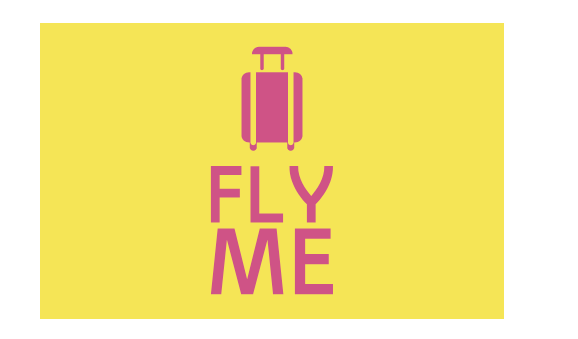


Fly Me a lancé un projet ambitieux de développement d’un chatbot pour aider les utilisateurs à choisir une offre de voyage.

La première étape de ce projet est de construire un MVP qui aidera les employés de Fly Me à réserver facilement un billet d’avion pour leurs vacances.


Pour la mise en place d'une V1 du projet, nous allons nous appuyer sur un jeu de données qui contient des historiques d'échange entre un chatbot et un utilisateur.

Nous souhaitons à cet effet recueillir des informations précises de notre jeu de données que sont:
- La ville d'origine (or_city)
- La ville de destination (dst_city)
- La date de départ du voyage (str_date)
- La date de retour du voyage (end_dte)
- Le budget du voyage (budget)

Ce notebook permet de mettre en place une analyse exploratoire des données (EDA), d'obtenir les informations clés recherchées et d'entraîner la base de données résultante pour la mise en place de l'application.



In [17]:
# Importation des librairies
import os
import json
import warnings
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import plotly.io as pio
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split

pio.renderers.default = "notebook"
pd.options.plotting.backend = "plotly"

In [2]:
os.chdir(r"C:\Users\Public\Projet_10")

In [3]:
# Chargement des données brutes

raw_data = pd.io.json.read_json("frames/frames.json")

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369 entries, 0 to 1368
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    1369 non-null   object
 1   turns      1369 non-null   object
 2   wizard_id  1369 non-null   object
 3   id         1369 non-null   object
 4   labels     1369 non-null   object
dtypes: object(5)
memory usage: 53.6+ KB


In [4]:
raw_data.describe(include="all")

,user_id,turns,wizard_id,id,labels
count,1369,1369,1369,1369,1369
unique,11,1369,12,1369,16
top,U22K1SX9N,[{'text': 'I'd like to book a trip to Atlantis...,U21T9NMKM,e2c0fc6c-2134-4891-8353-ef16d8412c9a,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
freq,345,1,301,1,929


## Premier aperçu

Notre jeu de données est constitué de **1369 dialogues** annotés (renseignés par la variable **turns**) de conversations entre un Humain et un Bot en vue de réserver un voyage. 

Nous allons extraire des informations contenues dans les variables **labels** et **turns**. Elles sont représentées par des dictionnaires avec des clés correspondant aux éléments que nous recherchons.

In [5]:
# Exemple de données collectées lors d'une conversation

raw_data["turns"][0]

[{'text': "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
  'labels': {'acts': [{'args': [{'val': 'book', 'key': 'intent'}],
     'name': 'inform'},
    {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
      {'val': 'Caprica', 'key': 'or_city'},
      {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
      {'val': '8', 'key': 'n_adults'},
      {'val': '1700', 'key': 'budget'}],
     'name': 'inform'}],
   'acts_without_refs': [{'args': [{'val': 'book', 'key': 'intent'}],
     'name': 'inform'},
    {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
      {'val': 'Caprica', 'key': 'or_city'},
      {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
      {'val': '8', 'key': 'n_adults'},
      {'val': '1700', 'key': 'budget'}],
     'name': 'inform'}],
   'active_frame': 1,
   'frames': [{'info': {'intent': [{'val': 'book', 'negated': False}],
      'budget': [{'val': '1700.0', 'negated': False}],

## Extraction des données pour entraînement avec LUIS 

In [7]:
def extract_data_for_luis(df):
    
    #création du dataframe
    col_names =  ['text', 'intent', 'or_city', 'dst_city', 'str_date', 'end_date', 'budget']
    Data_Luis  = pd.DataFrame(columns = col_names)
    
    #extracting des données
    for i in range(len(df)):

        text=""
        intent=""
        or_city=""
        dst_city=""
        str_date=""
        end_date=""
        budget=""

        #texte du message
        text=df['turns'][i][0]['text']

        #intention spécifiée
        if(len(df['turns'][i][0]['labels']['acts'])!=0):

            #Greeting
            if df['turns'][i][0]['labels']['acts'][0]['name']=='greeting':
                intent='greeting'

            #Intent
            for k in range(len(df['turns'][i][0]['labels']['acts'])):      
                if len(df['turns'][i][0]['labels']['acts'][k]['args'])!=0:
                    if df['turns'][i][0]['labels']['acts'][k]['args'][0]['key']=='intent':
                        intent=df['turns'][i][0]['labels']['acts'][k]['args'][0]['val']       
    
            #informations du message 1
            if (len(df['turns'][i][0]['labels']['acts'])>1):
                for j in range(len(df['turns'][i][0]['labels']['acts'][1]['args'])):
                    if df['turns'][i][0]['labels']['acts'][1]['args'][j]['key']=="or_city":
                        or_city=df['turns'][i][0]['labels']['acts'][1]['args'][j]['val']
                    if df['turns'][i][0]['labels']['acts'][1]['args'][j]['key']=="dst_city":
                        dst_city=df['turns'][i][0]['labels']['acts'][1]['args'][j]['val']
                    if df['turns'][i][0]['labels']['acts'][1]['args'][j]['key']=="str_date":
                        str_date=df['turns'][i][0]['labels']['acts'][1]['args'][j]['val']
                    if df['turns'][i][0]['labels']['acts'][1]['args'][j]['key']=="end_date":
                        end_date=df['turns'][i][0]['labels']['acts'][1]['args'][j]['val']  
                    if df['turns'][i][0]['labels']['acts'][1]['args'][j]['key']=="budget":
                        budget=df['turns'][i][0]['labels']['acts'][1]['args'][j]['val']
            
            #informations du message 2
            else:
                for j in range(len(df['turns'][i][0]['labels']['acts'][0]['args'])):
                    if df['turns'][i][0]['labels']['acts'][0]['args'][j]['key']=="or_city":
                        or_city=df['turns'][i][0]['labels']['acts'][0]['args'][j]['val']
                    if df['turns'][i][0]['labels']['acts'][0]['args'][j]['key']=="dst_city":
                        dst_city=df['turns'][i][0]['labels']['acts'][0]['args'][j]['val']
                    if df['turns'][i][0]['labels']['acts'][0]['args'][j]['key']=="str_date":
                        str_date=df['turns'][i][0]['labels']['acts'][0]['args'][j]['val']
                    if df['turns'][i][0]['labels']['acts'][0]['args'][j]['key']=="end_date":
                        end_date=df['turns'][i][0]['labels']['acts'][0]['args'][j]['val']  
                    if df['turns'][i][0]['labels']['acts'][0]['args'][j]['key']=="budget":
                        budget=df['turns'][i][0]['labels']['acts'][0]['args'][j]['val']

        #sans intention 
        else:
            intent="none"

        Data_Luis.loc[i] = [text, intent, or_city, dst_city, str_date, end_date, budget]

    return Data_Luis

In [8]:
Data_Luis = extract_data_for_luis(raw_data)

In [9]:
Data_Luis

,text,intent,or_city,dst_city,str_date,end_date,budget
0,I'd like to book a trip to Atlantis from Capri...,book,Caprica,Atlantis,"Saturday, August 13, 2016",,1700
1,"Hello, I am looking to book a vacation from Go...",book,Gotham City,Mos Eisley,,,2100
2,Hello there i am looking to go on a vacation w...,book,,Gotham City,,,
3,"Hi I'd like to go to Caprica from Busan, betwe...",book,Busan,Caprica,"Sunday August 21, 2016","Wednesday August 31, 2016",
4,"Hello, I am looking to book a trip for 2 adult...",book,Kochi,Denver,,,"$21,300"
...,...,...,...,...,...,...,...
1364,Hi I've got 9 days free and I'm looking for a ...,book,,,,,
1365,I need to get to Fortaleza on September 8th or...,book,,Fortaleza,September 8th,,
1366,We're finally going on vacation isn't that ama...,book,,,,,15600
1367,"Hi there, I'm looking for a place to get away ...",book,,,,,


In [10]:
# Nettoyage des données
#Remplacement des caractères relatifs à la monnaie
Data_Luis_Cleaned= Data_Luis
Data_Luis_Cleaned.replace({'-1': ""})
for i in ["$", "USD", "dollars", "dollar"]:
    Data_Luis_Cleaned['budget']=Data_Luis_Cleaned['budget'].apply(lambda x: x.replace(i,""))

# Remplacement des valeurs manquantes et de la valeur -1
Data_Luis_Cleaned.replace({np.nan: ""})
Data_Luis_Cleaned.replace({'-1': ""})
# Aperçu
Data_Luis_Cleaned


,text,intent,or_city,dst_city,str_date,end_date,budget
0,I'd like to book a trip to Atlantis from Capri...,book,Caprica,Atlantis,"Saturday, August 13, 2016",,1700
1,"Hello, I am looking to book a vacation from Go...",book,Gotham City,Mos Eisley,,,2100
2,Hello there i am looking to go on a vacation w...,book,,Gotham City,,,
3,"Hi I'd like to go to Caprica from Busan, betwe...",book,Busan,Caprica,"Sunday August 21, 2016","Wednesday August 31, 2016",
4,"Hello, I am looking to book a trip for 2 adult...",book,Kochi,Denver,,,"21,300"
...,...,...,...,...,...,...,...
1364,Hi I've got 9 days free and I'm looking for a ...,book,,,,,
1365,I need to get to Fortaleza on September 8th or...,book,,Fortaleza,September 8th,,
1366,We're finally going on vacation isn't that ama...,book,,,,,15600
1367,"Hi there, I'm looking for a place to get away ...",book,,,,,


In [11]:
# Retrait de la valeur -1 des noms de villes
Data_Luis_Cleaned['dst_city']=Data_Luis_Cleaned['dst_city'].replace({'-1': ""})
Data_Luis_Cleaned['or_city']=Data_Luis_Cleaned['or_city'].replace({'-1': ""})
Data_Luis_Cleaned

,text,intent,or_city,dst_city,str_date,end_date,budget
0,I'd like to book a trip to Atlantis from Capri...,book,Caprica,Atlantis,"Saturday, August 13, 2016",,1700
1,"Hello, I am looking to book a vacation from Go...",book,Gotham City,Mos Eisley,,,2100
2,Hello there i am looking to go on a vacation w...,book,,Gotham City,,,
3,"Hi I'd like to go to Caprica from Busan, betwe...",book,Busan,Caprica,"Sunday August 21, 2016","Wednesday August 31, 2016",
4,"Hello, I am looking to book a trip for 2 adult...",book,Kochi,Denver,,,"21,300"
...,...,...,...,...,...,...,...
1364,Hi I've got 9 days free and I'm looking for a ...,book,,,,,
1365,I need to get to Fortaleza on September 8th or...,book,,Fortaleza,September 8th,,
1366,We're finally going on vacation isn't that ama...,book,,,,,15600
1367,"Hi there, I'm looking for a place to get away ...",book,,,,,


In [39]:
# Enregistrement du fichier résultat
Data_Luis_Cleaned.to_csv("Data_Luis_Cleaned.csv", index=False)

## Préparation des données pour entraînement et test

In [12]:
# Intention  réservation "book"
data_book = Data_Luis_Cleaned[Data_Luis_Cleaned['intent'] =='book']
data_book = data_book.reset_index(drop=True)

# Intention  réservation "greeting"
data_greeting = Data_Luis_Cleaned[Data_Luis_Cleaned['intent'] == 'greeting']
data_greeting = data_greeting.reset_index(drop=True)

# Intention  réservation "none"
data_none = Data_Luis_Cleaned[Data_Luis_Cleaned['intent'] == 'none']
data_none = data_none.reset_index(drop=True)





In [13]:
data_book

,text,intent,or_city,dst_city,str_date,end_date,budget
0,I'd like to book a trip to Atlantis from Capri...,book,Caprica,Atlantis,"Saturday, August 13, 2016",,1700
1,"Hello, I am looking to book a vacation from Go...",book,Gotham City,Mos Eisley,,,2100
2,Hello there i am looking to go on a vacation w...,book,,Gotham City,,,
3,"Hi I'd like to go to Caprica from Busan, betwe...",book,Busan,Caprica,"Sunday August 21, 2016","Wednesday August 31, 2016",
4,"Hello, I am looking to book a trip for 2 adult...",book,Kochi,Denver,,,"21,300"
...,...,...,...,...,...,...,...
1129,Hi I've got 9 days free and I'm looking for a ...,book,,,,,
1130,I need to get to Fortaleza on September 8th or...,book,,Fortaleza,September 8th,,
1131,We're finally going on vacation isn't that ama...,book,,,,,15600
1132,"Hi there, I'm looking for a place to get away ...",book,,,,,


In [14]:
data_greeting

,text,intent,or_city,dst_city,str_date,end_date,budget
0,Hi!,greeting,,,,,
1,Hi! I'd like to go to Boston from Mos Eisley o...,greeting,Mos Eisley,Boston,August 15th,,
2,Heyo!,greeting,,,,,
3,Good morning.,greeting,,,,,
4,Hello wozbot!,greeting,,,,,
...,...,...,...,...,...,...,...
136,hi there. i really wanna pretend im somewhere ...,greeting,,,,,2900
137,Guess what? I'm a recently married person look...,greeting,osaka,manaus,,,
138,Hi,greeting,,,,,
139,Hi,greeting,,,,,


In [15]:
data_none

,text,intent,or_city,dst_city,str_date,end_date,budget
0,"Have you ever read the book ""Vernon's Travels""?",none,,,,,
1,psssstttttt,none,,,,,
2,Vacay time woooohooooooo,none,,,,,


In [18]:
# Séparation des jeux de données pour entraînement et tests

data_book_train, data_book_test = train_test_split(data_book, train_size=0.5,random_state=0 )
data_book_train = data_book_train. reset_index(drop=True)
data_book_test = data_book_test. reset_index(drop=True)

data_greeting_train, data_greeting_test = train_test_split(data_greeting, train_size=0.5,random_state=0 )
data_greeting_train = data_greeting_train. reset_index(drop=True)
data_greeting_test = data_greeting_test. reset_index(drop=True)


In [19]:
data_book_train

,text,intent,or_city,dst_city,str_date,end_date,budget
0,Any week long trips to Brasilia from Mannheim ...,book,Mannheim,Brasilia,august 30,september 15,
1,Hello! I recently won the internship lottery t...,book,Alexandria,Kobe,,,
2,Hi i want to go to burlington,book,,burlington,,,
3,hello!,book,,,,,
4,I want to leave Kabul on or after Sept 6 please,book,Kabul,,Sept 6,,
...,...,...,...,...,...,...,...
562,Need two tickets out of Buenos Aires!,book,Buenos Aires,,,,
563,YOU FLY OUT OF BEIJING?,book,BEIJING,,,,
564,"Hi there, I'd like to book a trip from Boston ...",book,Boston,,,,
565,Jerusalem to Belem 2 adults 4000 dollar budget...,book,Jerusalem,Belem,September third,,4000


In [20]:
data_book_test

,text,intent,or_city,dst_city,str_date,end_date,budget
0,Hey hey. Got 6 days off starting Sept 8. Flyin...,book,Cleveland,,Sept 8,,
1,"Hi yes, to Jerusalem please.",book,,Jerusalem,,,
2,You got any flights from New York to Naples de...,book,New York,Naples,Aug 27,Sep 15,
3,Hello. me and my grand child would like to go ...,book,,,,,
4,i need a trip under the radar from mannheim to...,book,mannheim,fukuoka,,august 30th,
...,...,...,...,...,...,...,...
562,Good afternoon. I'd like to book a business tr...,book,Mannheim,New York,,,
563,yes. i am going 2 bring my grand daughter with...,book,,,,,
564,This is a little short notice But I'm trying t...,book,San Diego,,Sept 8,17,
565,HI I NEED TO GO ON VACATION I LIVE IN WASHINGT...,book,,,,,


In [21]:
data_greeting_train

,text,intent,or_city,dst_city,str_date,end_date,budget
0,Hi there!,greeting,,,,,
1,hey,greeting,,,,,
2,"Hello, kind stranger.",greeting,,,,,
3,Hi there!,greeting,,,,,
4,Howdy! So how does this work? I'm not too good...,greeting,,,,,
...,...,...,...,...,...,...,...
65,hi my wife and i wanna bring our 7 little lads...,greeting,san diego,kochi,,,28500
66,Hi! Can you get me a trip from FOrtaleza to Pu...,greeting,FOrtaleza,Puebla,,,
67,EXCUSE ME,greeting,,,,,
68,You too!,greeting,,,,,


In [22]:
data_greeting_test

,text,intent,or_city,dst_city,str_date,end_date,budget
0,Good day. I live in Kabul and I want to take m...,greeting,Kabul,,,,
1,Hello there!,greeting,,,,,
2,hi there,greeting,,,,,
3,hey,greeting,,,,,
4,Heya,greeting,,,,,
...,...,...,...,...,...,...,...
66,Hi,greeting,,,,,
67,hello hello,greeting,,,,,
68,hiya,greeting,,,,,
69,Hi there,greeting,,,,,


 ## Création de l'application et entraînement (LUIS)

In [25]:
# Importation des librairies
import time
import getpass
import uuid
import datetime
from pprint import pprint

from azure.cognitiveservices.language.luis.authoring import LUISAuthoringClient
from azure.cognitiveservices.language.luis.authoring.models import ApplicationCreateObject
from azure.cognitiveservices.language.luis.runtime import LUISRuntimeClient

from msrest.authentication import CognitiveServicesCredentials



In [ ]:
#!pip install azure_cognitiveservices-language-luis

In [19]:
# Configuration
my_authoring_key = getpass.getpass("Veuillez entrer votre clé d'auteur")
my_authoring_endpoint = getpass.getpass("Veuillez entrer votre Url d'auteur")
my_prediction_key = getpass.getpass("Veuillez entrer votre clé de prédiction")
my_prediction_endpoint = getpass.getpass("Veuillez entrer votre Url de prédiction")

print( "Prêt à utiliser le service cognitif LUIS d'Azure")



Veuillez entrer votre clé d'auteur········
Veuillez entrer votre Url d'auteur········
Veuillez entrer votre clé de prédiction········
Veuillez entrer votre Url de prédiction········
Prêt à utiliser le service cognitif LUIS d'Azure


In [26]:
intent_name_order = "OrderTravelIntent"
authoring_key = '3fb3877b71a3408db4f27c349ce7fb53'
authoring_endpoint = 'https://myluisapp88-authoring.cognitiveservices.azure.com'
prediction_key = '997a64c1e76a4a17bafad2584b7726b3'
prediction_endpoint = 'https://myluisapp88.cognitiveservices.azure.com'
version_id="0.1"

In [29]:
# Fonction permettant la création de l'application LUIS
def booking_app(subscription_key,  version_id):
    
    """Authoring.
    This will create a LUIS Booking application, train and publish it.
    """
    client = LUISAuthoringClient(
        'https://myluisapp88-authoring.cognitiveservices.azure.com',
        CognitiveServicesCredentials(subscription_key))

        # Create a LUIS app
    default_app_name = "FlyMeBookingApp88"
        
    print("Creating App {}, version {}".format(default_app_name, version_id))
    
    app_id = client.apps.add({
            'name': default_app_name,
            'initial_version_id': version_id,
            'description': "New App created with LUIS Python sample",
            'culture': 'en-us'})
        
    print("Created app {}".format(app_id))

In [30]:
booking_app (authoring_key, version_id)

Creating App FlyMeBookingApp88, version 0.1
Created app 75e08333-d14c-4525-9925-25cf1499ac37


In [31]:
# Récupération des éléments clés de l'app basique
client = LUISAuthoringClient(
        'https://myluisapp88-authoring.cognitiveservices.azure.com',
        CognitiveServicesCredentials(authoring_key))

app_name = "FlyMeBookingApp88"

app_id = '75e08333-d14c-4525-9925-25cf1499ac37'

In [32]:
# Création des phrases, des entités, et de leurs valeurs

intent_name_order = "OrderTravelIntent"

def extract_label(utterance, entity_name, value):
    utterance = utterance.lower()
    value = value.lower()
    return {
        'entity_name':entity_name,
        'start_char_index': utterance.find(value),
        'end_char_index': utterance.find(value) + len(value)
    }

In [33]:
def add_order_intent(client, version_id, app_id):
    #add intent
    intent_id_order = client.model.add_intent(app_id, version_id, intent_name_order)

In [34]:
def add_order_entities(client, version_id, app_id):
    #add Prebuilt entity
    client.model.add_prebuilt(app_id, version_id, prebuilt_extractor_names=["datetimeV2"])
    
    #add entities
    departure_city_name = "DepartureCity"
    departure_city_id = client.model.add_entity(app_id, version_id, name=departure_city_name)

    arrival_city_name = "ArrivalCity"
    arrival_city_id = client.model.add_entity(app_id, version_id, name=arrival_city_name)

    departure_date_name = "DepartureDate"
    departure_date_id = client.model.add_entity(app_id, version_id, name=departure_date_name)

    arrival_date_name = "ArrivalDate"
    arrival_date_id = client.model.add_entity(app_id, version_id, name=arrival_date_name)

    price_name = "Price"
    price_id = client.model.add_entity(app_id, version_id, name=price_name)

In [35]:
def add_utterances_order(client, version_id, app_id, nb_utterances_to_add):

    utterances_order = []

    for i in range(min(nb_utterances_to_add, len(data_book_train))):

        entity_labels = []

        if (data_book_train.iloc[i][2]!=''):
            entity_labels.append(extract_label(data_book_train.iloc[i][0], "DepartureCity", data_book_train.iloc[i][2]))

        if (data_book_train.iloc[i][3]!=''):
            entity_labels.append(extract_label(data_book_train.iloc[i][0], "ArrivalCity", data_book_train.iloc[i][3]))

        if (data_book_train.iloc[i][4]!=''):
            entity_labels.append(extract_label(data_book_train.iloc[i][0], "DepartureDate", data_book_train.iloc[i][4]))

        if (data_book_train.iloc[i][5]!=''):
            entity_labels.append(extract_label(data_book_train.iloc[i][0], "ArrivalDate", data_book_train.iloc[i][5]))

        if (data_book_train.iloc[i][6]!=''):
            entity_labels.append(extract_label(data_book_train.iloc[i][0], "Price", data_book_train.iloc[i][6]))

        utterances_order.append({
            'text': data_book_train.iloc[i][0],
            'intent_name': intent_name_order,
            'entity_labels': entity_labels
        })
    
    print(f"Nb utterances_order to add = {len(utterances_order)}")
    
    #as we can only add 100 utterances per batch we use a loop to add all utterances
    j = len(utterances_order)
    k = 0
    while ((j-100)>0):
        utterances_result = client.examples.batch(app_id, version_id, utterances_order[k:k+100])
        j = j-100
        k = k+100

    utterances_result = client.examples.batch(app_id, version_id, utterances_order[k:len(utterances_order)])
    
    print("\nUtterances added to the {} intent".format(intent_name_order))

In [36]:
#add intent
add_order_intent(client, version_id, app_id)

#add entities
add_order_entities(client, version_id, app_id)

#add utterances
add_utterances_order(client, version_id, app_id, nb_utterances_to_add=len(data_book_train))

Nb utterances_order to add = 567

Utterances added to the OrderTravelIntent intent


In [37]:
intent_name_greetings = "GreetingsIntent"
def add_greetings_intent(client, version_id, app_id):
    # add intent
    intent_id_greetings = client.model.add_intent(app_id, version_id, intent_name_greetings)

In [38]:
def add_utterances_greetings(client, version_id, app_id, nb_utterances_to_add):

    utterances_greetings = []

    for i in range(min(nb_utterances_to_add, len(data_greeting_train), 100)):

        utterances_greetings.append({
            'text': data_greeting.iloc[i][0],
            'intent_name': intent_name_greetings,
        })   
        
    print(f"Nb utterances_greetings to add = {len(utterances_greetings)}")
    
    utterances_result = client.examples.batch(app_id, version_id, utterances_greetings)
    
    print("\nUtterances added to the {} intent".format(intent_name_greetings))


In [39]:
#add intent
add_greetings_intent(client, version_id, app_id)

#add utterances
add_utterances_greetings(client, version_id, app_id, nb_utterances_to_add=len(data_greeting_train))

Nb utterances_greetings to add = 70

Utterances added to the GreetingsIntent intent


Etant donné que notre base de données pour l'intention None est pauvre (3 observations), nous allons un minimum l'enrichir afin que l'entraînement soit consistant.

In [40]:
data_none

,text,intent,or_city,dst_city,str_date,end_date,budget
0,"Have you ever read the book ""Vernon's Travels""?",none,,,,,
1,psssstttttt,none,,,,,
2,Vacay time woooohooooooo,none,,,,,


In [41]:
#Exemples éloignés du contexte
added_none_1 = "The AI training is quit interesting"  
added_none_2 = "I feel good"
added_none_3 = "It's a sunny day"
added_none_4 = "Love is all the world need"

#Exemples proches du contexte
added_none_5 = "I'd like to rent a boat"
added_none_6 = "find an hotel near me"
added_none_7 = "I would like to book a restaurant"
added_none_8 = "I need to rent a car"

added_nones = [added_none_1, added_none_2, added_none_3, added_none_4, added_none_5, added_none_6, added_none_7, added_none_8]



In [42]:
added_nones

['The AI training is quit interesting',
 'I feel good',
 "It's a sunny day",
 'Love is all the world need',
 "I'd like to rent a boat",
 'find an hotel near me',
 'I would like to book a restaurant',
 'I need to rent a car']

In [43]:
 for i, added in enumerate(added_nones):
        print(added) 


The AI training is quit interesting
I feel good
It's a sunny day
Love is all the world need
I'd like to rent a boat
find an hotel near me
I would like to book a restaurant
I need to rent a car


In [44]:
# Ajout des exemples à la base
def add_none (data, added_n):
    for i, added in enumerate(added_n):
        data = data.append({'text' : added,
                            'intent': 'none' ,
                            'or_city' : '',
                            'dst_city' : '',
                            'str_date' : '',
                            'end_date' : '',
                            'budget' : ''}, ignore_index=True)
    return data

In [45]:
data_none = add_none(data_none, added_nones)

In [46]:
data_none

,text,intent,or_city,dst_city,str_date,end_date,budget
0,"Have you ever read the book ""Vernon's Travels""?",none,,,,,
1,psssstttttt,none,,,,,
2,Vacay time woooohooooooo,none,,,,,
3,The AI training is quit interesting,none,,,,,
4,I feel good,none,,,,,
5,It's a sunny day,none,,,,,
6,Love is all the world need,none,,,,,
7,I'd like to rent a boat,none,,,,,
8,find an hotel near me,none,,,,,
9,I would like to book a restaurant,none,,,,,


In [47]:
#intent_name_none = "NoneIntent"
#def add_none_intent(client, version_id, app_id):
    #add intent
    #intent_id_none = client.model.add_intent(app_id, version_id, intent_name_none)
    
#add intent
#add_none_intent(client, version_id, app_id)
    

Etant donné que nous avons l'intention None qui est crée par défaut dans notre Luis App, nous allons simplement lui ajouter des utterances"

In [48]:
intent_name_none = "None"
def add_utterances_none(client, version_id, app_id, nb_utterances_to_add):

    utterances_none = []

    for i in range(min(nb_utterances_to_add, len(data_none), 100)):

        utterances_none.append({
            'text': data_none.iloc[i][0],
            'intent_name': intent_name_none,
        })
        
    print(f"Nb utterances_none to add = {len(utterances_none)}")
        
    utterances_result = client.examples.batch(app_id, version_id, utterances_none)
    
    print("\nUtterances added to the {} intent".format(intent_name_none))

In [49]:
#add utterances
add_utterances_none(client, version_id, app_id, nb_utterances_to_add=len(data_none))

Nb utterances_none to add = 11

Utterances added to the None intent


### Entraînement

In [50]:
def train_model(client, version_id, app_id):
    # Training the model
    print("\nWe'll start training your app...")

    async_training = client.train.train_version(app_id, version_id)
    is_trained = async_training.status == "UpToDate"

    trained_status = ["UpToDate", "Success"]
    while not is_trained:
        time.sleep(1)
        status = client.train.get_status(app_id, version_id)
        is_trained = all(m.details.status in trained_status for m in status)

    print("Your app is trained. You can now go to the LUIS portal and test it!")

In [51]:
train_model(client, version_id, app_id)


We'll start training your app...
Your app is trained. You can now go to the LUIS portal and test it!


### Publication

In [52]:
def publish_model(client, version_id, app_id):
    client.apps.update_settings(app_id, is_public=True)
    client.apps.publish(app_id, version_id, is_staging=False)

In [53]:
publish_model(client, version_id, app_id)

### Evaluation

In [54]:
def create_luis_client_runtime():
    runtime_credentials = CognitiveServicesCredentials(prediction_key)
    client_runtime = LUISRuntimeClient(endpoint=prediction_endpoint, credentials=runtime_credentials)
    
    return client_runtime

In [55]:
client_runtime = create_luis_client_runtime()

In [56]:
# Evaluation sur notre jeu de test de l'entité des reservation "book"
data_book_test

,text,intent,or_city,dst_city,str_date,end_date,budget
0,Hey hey. Got 6 days off starting Sept 8. Flyin...,book,Cleveland,,Sept 8,,
1,"Hi yes, to Jerusalem please.",book,,Jerusalem,,,
2,You got any flights from New York to Naples de...,book,New York,Naples,Aug 27,Sep 15,
3,Hello. me and my grand child would like to go ...,book,,,,,
4,i need a trip under the radar from mannheim to...,book,mannheim,fukuoka,,august 30th,
...,...,...,...,...,...,...,...
562,Good afternoon. I'd like to book a business tr...,book,Mannheim,New York,,,
563,yes. i am going 2 bring my grand daughter with...,book,,,,,
564,This is a little short notice But I'm trying t...,book,San Diego,,Sept 8,17,
565,HI I NEED TO GO ON VACATION I LIVE IN WASHINGT...,book,,,,,


In [57]:
def eval_order_intent(data_book_test, test_size, app_id, client_runtime):

    correct_intents=0
    correct_entities=0

    list_strip = ['.', '!', '?', ',']
    
    for i in range(min(test_size, len(data_book_test))):

        text = data_book_test.iloc[i][0]
        predictionRequest = { "query" : text}

        predictionResponse = client_runtime.prediction.get_slot_prediction(app_id, "Production", predictionRequest)
        top_intent = predictionResponse.prediction.top_intent

        if (top_intent=="OrderTravelIntent"):
              correct_intents+=1

        departure_city = data_book_test.iloc[i][2]
        try:
            departure_city_predicted = predictionResponse.prediction.entities['DepartureCity'][0]
            for strip in list_strip :
                departure_city_predicted = departure_city_predicted.rstrip(strip)
            if departure_city_predicted == departure_city:
                correct_entities+=1
        except:
            if departure_city=='':
                correct_entities+=1

        arrival_city = data_book_test.iloc[i][3]
        try:
            arrival_city_predicted = predictionResponse.prediction.entities['ArrivalCity'][0]
            for strip in list_strip :
                arrival_city_predicted = arrival_city_predicted.rstrip(strip)
            if arrival_city_predicted == arrival_city:
                correct_entities+=1
        except:
            if arrival_city=='':
                correct_entities+=1

        departure_date = data_book_test.iloc[i][4]
        try:
            departure_date_predicted = predictionResponse.prediction.entities['DepartureDate'][0]
            for strip in list_strip :
                departure_date_predicted = departure_date_predicted.rstrip(strip)
            if departure_date_predicted == departure_date:
                correct_entities+=1
        except:
            if departure_date=='':
                correct_entities+=1

        arrival_date = data_book_test.iloc[i][5]
        try:
            arrival_date_predicted = predictionResponse.prediction.entities['ArrivalDate'][0]
            for strip in list_strip :
                arrival_date_predicted = arrival_date_predicted.rstrip(strip)
            if arrival_date_predicted == arrival_date:
                correct_entities+=1
        except:
            if arrival_date=='':
                correct_entities+=1

        price = data_book_test.iloc[i][6]
        try:
            price_predicted = predictionResponse.prediction.entities['Price'][0]
            for strip in list_strip :
                price_predicted = price_predicted.rstrip(strip)
            if price_predicted == price:
                correct_entities+=1
        except:
            if price=='':
                correct_entities+=1

    print(f"intention détectée = {correct_intents/test_size:.2f}")

    print(f"entitées détectées = {correct_entities/(test_size*5):.2f}")

In [58]:
test_size = 100
eval_order_intent(data_book_test, test_size, app_id, client_runtime)

intention détectée = 0.99
entitées détectées = 0.83


In [59]:
# Evaluation sur notre jeu de test de l'entité des salutations "greetings"

def eval_greeting_intent(data_greeting_test, test_size, app_id, client_runtime):

    correct_intents=0

    for i in range(min(test_size,len(data_greeting_test))):

        text = data_greeting_test.iloc[i][0]
        predictionRequest = { "query" : text}

        predictionResponse = client_runtime.prediction.get_slot_prediction(app_id, "Production", predictionRequest)
        top_intent = predictionResponse.prediction.top_intent

        if (top_intent=="GreetingsIntent"):
              correct_intents+=1

    print(f"intention détectées = {correct_intents/test_size:.2f}")   

In [60]:
test_size = len(data_greeting_test)
eval_greeting_intent(data_greeting_test, test_size, app_id, client_runtime)

intention détectées = 0.80
